In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

# 0. Configs

In [2]:
OOD_TARGETS_SCORES_FOCUS = {
    'MAIN_METHODS': ['vim', 'msp', 'odin'], # main paper supports
    'FULL_METHODS': ['vim', 'msp', 'odin', 'ash','react'], # appendix supports
    'LEFT_METHODS': ['react', 'ash'], # appendix supports
}

OOD_TARGETS_PERFORMANCE_FOCUS = ['vim', 'msp', 'odin', 'react', 'ash']

MODEL_FULL_NAME = {
    'SWIN': 'swin_base_patch4_window7_224',
    'EN': 'efficientnet_b0.ra_in1k',
    'RN18':'resnet18.a1_in1k',
    'VIT':'deit_base_patch16_224.fb_in1k',
}

SETTING_KEYWORD_MAP = {
    'SEMANTICS-CENTRIC': 'SC',
    'MS-OOD': 'MC',
}

# 1. Select Analysis Options

In [63]:
from configs.datasets import DATA_ROOT_DIR

model = 'VIT'
ood_targets = 'FULL_METHODS'
TEST_DATA_ROOT_DIR = f'{DATA_ROOT_DIR}/es-test'
RESULT_DIR = 'results_new_labeler_paper_written_ver'

# 2. Load Data

In [64]:
import torch as ch
import os

def load_data(model_name):
    os.makedirs(f'{MODEL_RESULT_DIR}/ood-dist/', exist_ok=True)
    os.makedirs(f'{MODEL_RESULT_DIR}/scatter-plots/', exist_ok=True)
    loaded_data =  dict(map(lambda item: (item[0], {
        'metrics': ch.load(f'{MODEL_RESULT_DIR}/TIN2-{item[1]}.pt'),
        'scores': ch.load(f'{MODEL_RESULT_DIR}/TIN2-{item[1]}_scores.pt'),
    }), SETTING_KEYWORD_MAP.items()))
    return loaded_data

model_name = MODEL_FULL_NAME[model]
MODEL_RESULT_DIR = f'./{RESULT_DIR}/{model_name}'

loaded = load_data(MODEL_FULL_NAME[model])
accs = ch.load(f'{TEST_DATA_ROOT_DIR}/{model_name}_param_control_acc.pt')

# 3. Plot OOD Score Distributions

Which framework is more valid under ImageNet-ES (i.e. C-OOD data) between the "semantics-centric framework" and the "MS-OOD framework"?

<Semantics-centric framework>


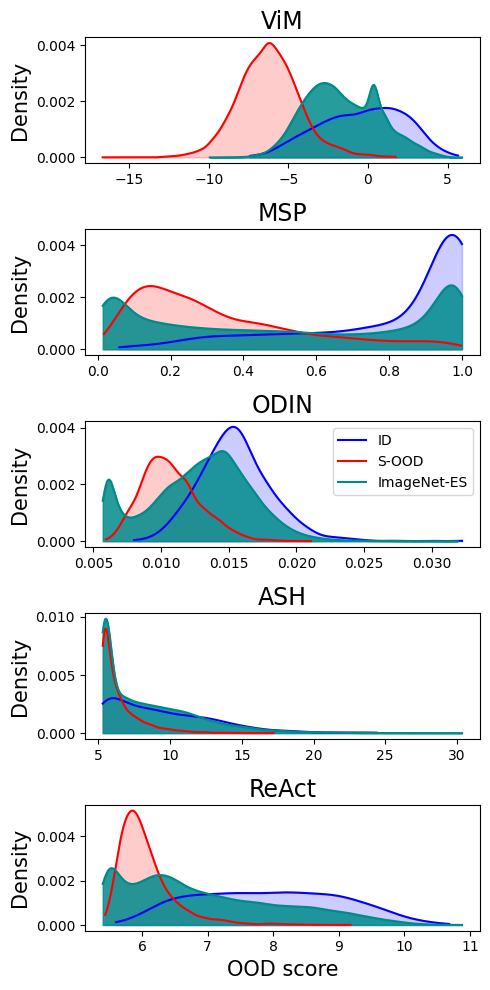

<MS-OOD framework>


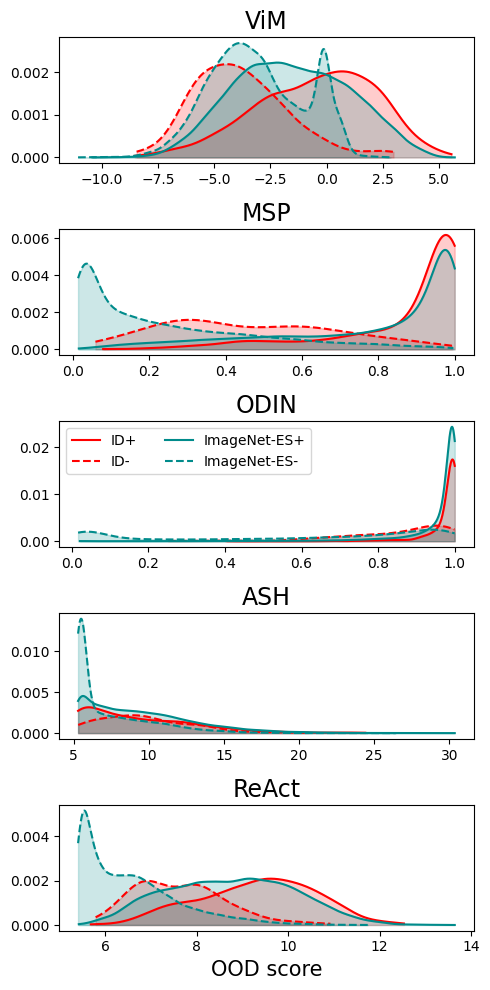

In [5]:
from utils.histogram import Histogram

s_ood = 'textures'

target_methods = OOD_TARGETS_SCORES_FOCUS[ood_targets]

scood = loaded['SEMANTICS-CENTRIC']['scores']
msood = loaded['MS-OOD']['scores']

if ood_targets == 'MAIN_METHODS':
    hist = Histogram()
elif ood_targets == 'LEFT_METHODS':
    hist = Histogram(fig_size=(5,3.4))
else: # FULL METHODS
    hist = Histogram(fig_size=(5,10))

FILE_NAME_SC = f'{MODEL_RESULT_DIR}/ood-dist/SEMANTICS-CENTRIC_{ood_targets}.pdf'
FILE_NAME_MC = f'{MODEL_RESULT_DIR}/ood-dist/MS-OOD_{ood_targets}.pdf'

print('<Semantics-centric framework>')
hist.draw_scood(scood, target_methods, s_ood=s_ood, legend_loc='odin', file_name=FILE_NAME_SC)

print('<MS-OOD framework>')
hist.draw_msood(msood, target_methods, s_ood=s_ood, legend_loc='odin', file_name=FILE_NAME_MC)

# 4. Plot OOD Score - Accuracy

In [84]:
from utils.scatter import Scatters

legend_fontsize = 12

legend_dict = {
    'loc': (0.17, 0.6),
    'ncol': 2,
    'handlelength': 0.05,
    'prop': {'size':9},
}

target_methods = OOD_TARGETS_PERFORMANCE_FOCUS
sc = Scatters(methods=target_methods, figsize=(6,3), legend_fontsize=12)

axis_selection = {
    'ax1': set(['vim', 'knn', 'ash', 'react']) & set(target_methods),
    'ax2': set(['msp', 'odin']) & set(target_methods),
}

<MS-OOD setting>


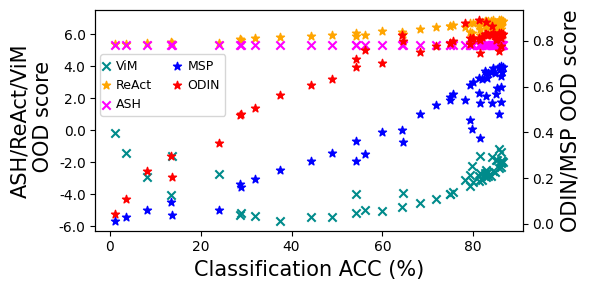

In [85]:
msood_scores = loaded['MS-OOD']['scores']

print('<MS-OOD setting>')
FILE_NAME = f'{MODEL_RESULT_DIR}/oodscore-acc-{model_name}_MS-OOD.pdf'
sc.plot_score_accuracy(msood_scores, accs, axis_selection, legend_dict=legend_dict,
                       file_name=FILE_NAME)

# 5. Plot SOOD Performance

In [86]:
from utils.scatter import Scatters

legend_fontsize = 11.5

target_methods = OOD_TARGETS_PERFORMANCE_FOCUS
sc = Scatters(methods=target_methods, figsize=(5,3), legend_fontsize=legend_fontsize)

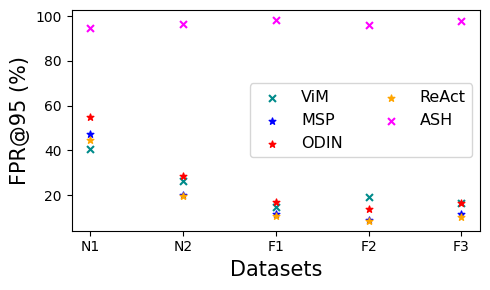

In [87]:
# ood detection is trained without ImageNet-ES (vanilla MS-OOD settings)

metrics = loaded['MS-OOD']['metrics']

FILE_NAME = f'{MODEL_RESULT_DIR}/scatter-plots/MS-OOD_fpr_{ood_targets}.pdf'
sc.plot_sood_performance(metrics, target_metric='FPR@95', file_name=FILE_NAME, legend_dict={'ncol':2})

# 6. Plot F1 Score

<MS-OOD setting>


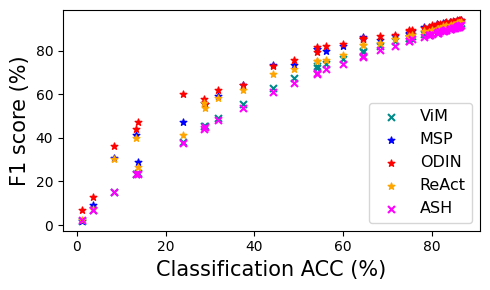

In [88]:
# C-OOD Performance on MS-OOD setting

legend_fontsize = 11.5

msood_scores = loaded['MS-OOD']['scores']
target_methods = OOD_TARGETS_PERFORMANCE_FOCUS

sc = Scatters(methods=target_methods, figsize=(5,3), legend_fontsize=legend_fontsize)

print('<MS-OOD setting>')
FILE_NAME = f'{MODEL_RESULT_DIR}/f1score_{model_name}_MS-OOD_{ood_targets}.pdf'
sc.plot_f1_accuracy(msood_scores, accs, file_name=FILE_NAME)